# 문항2

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
! ls
% cd Mecab-ko-for-Google-Colab
! bash install_mecab-ko_on_colab190912.sh

'apt-get'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'apt-get'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
Cloning into 'Mecab-ko-for-Google-Colab'...
'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
UsageError: Line magic function `%` not found.


In [13]:
from pandas import DataFrame
from pandas import read_excel
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# 한글 형태소 분석
# -> window
from eunjeon import Mecab
# -> mac, linux(colab)
#from konlpy.tag import Mecab
#from konlpy.tag import Okt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
df1 = read_excel('뉴스제목.xlsx', engine='openpyxl')
df = df1.filter(['label', 'document'])

In [7]:
df

,label,document
0,정치,송영길 순진한 김경수 드루킹에 이용박근혜 때 국정원 조작
1,정치,대법 징역년 확정에 김경수 그래도 진실 안 바뀌어
2,정치,저격수 추미애 주시간 발언으로 세상 이치 모른다는 것 드러내
3,정치,추미애 댓글 팀킬 결과에 김경수 광신자 배려 올가미됐다
4,정치,김경수 징역안타까워 대통령 사과해야
...,...,...
31238,IT/과학,암호화폐 거래소 코빗 개인정보보호법 위반으로 과태료 만원 부과
31239,IT/과학,공정위 멜론 부당지원 제재 법적대응 예고
31240,IT/과학,취재수첩 년간 임금인상률 인데 연봉 왜 문제인가
31241,IT/과학,셧다운제 폐지 논란 불쏘시개 된 금 마인크래프트


In [8]:
df.label.replace("정치", 0, inplace=True)
df.label.replace("경제", 1, inplace=True)
df.label.replace("사회", 2, inplace=True)
df.label.replace("생활문화", 3, inplace=True)
df.label.replace("세계", 4, inplace=True)
df.label.replace("IT/과학", 5, inplace=True)
df['label'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [9]:
df.groupby('label').count()

,document
label,
0,6141
1,8183
2,9985
3,2239
4,2925
5,1770


In [14]:
mecab = Mecab()
morphs = mecab.morphs(df['document'][0])

print(morphs)

['송영길', '순진', '한', '김경수', '드루', '킹', '에', '이용', '박근혜', '때', '국정원', '조작']


In [15]:
stopwords = ['었','을','것','없', '이나','너','니','다','절','떨','고','있','나','김','에서','믿','는다','에서','하','라','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '걍']

In [17]:
word_set = []

for i, v in enumerate(df['document']):
    #morphs = okt.morphs(v)
    morphs = mecab.morphs(v)
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)
            
    word_set.append(tmp_word)
    
# 상위 3건만 출력해서 확인
word_set[:10]

[['송영길', '순진', '김경수', '드루', '킹', '이용', '박근혜', '때', '국정원', '조작'],
 ['대법', '징', '역년', '확정', '김경수', '그래도', '진실', '안', '바뀌', '어'],
 ['저격수', '추미애', '주', '시간', '발언', '세상', '이치', '모른다는', '드러내'],
 ['추미애', '댓글', '팀킬', '결과', '김경수', '광신자', '배려', '올가미', '됐'],
 ['김경수', '징역', '안타까워', '대통령', '사과', '해야'],
 ['여야', '법사', '위원장', '입장', '차', '여', '전월', '국회', '서', '표결', '강행', '할', '듯'],
 ['안철수', '김경수', '경남', '지사', '유죄', '판결', '사필귀정'],
 ['윤희숙', '이재명', '기본소득', '스스로', '씹', '어', '먹', '어', '너무', '말', '안', '돼'],
 ['최재형', '생전', '처음', '헤어', '펌', '사진', '페북', '개시'],
 ['김경수', '중도', '퇴진', '경', '남도', '권한', '대행', '벌써', '번', '째']]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
len(tokenizer.word_index)

22243

In [19]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 22243
등장 빈도가 2번 이하인 희귀 단어의 수: 11627
단어 집합에서 희귀 단어의 비율: 52.27262509553567
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.679164373582396


In [20]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 10618


In [21]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
len(token_set)

31243

In [22]:
import json
with open("word_index.json", "w", encoding='utf-8') as f:
    json = json.dumps(tokenizer.word_index)
    f.write(json)

# 문항 3

In [23]:
drop_train = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_train.append(i)
        
len(drop_train)

3

In [24]:
fill_token_set = np.delete(token_set, drop_train, axis=0)
len(fill_token_set)

c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


31240

In [25]:
lables = np.delete(np.array(df['label']), drop_train)
len(lables)

31240

리뷰의 최대 길이 : 31
리뷰의 평균 길이 : 10.062451984635084


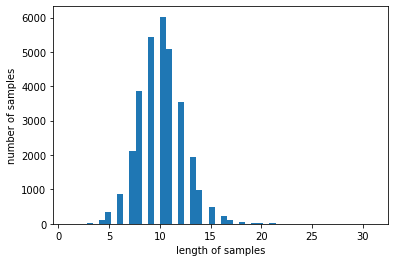

In [26]:
print('리뷰의 최대 길이 :',max(len(l) for l in fill_token_set))
print('리뷰의 평균 길이 :',sum(map(len, fill_token_set))/len(fill_token_set))
plt.hist([len(s) for s in fill_token_set], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
pad_token_set = pad_sequences(fill_token_set, maxlen=30)

# 문항 4

In [28]:
np.random.seed(777)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, lables, test_size = 0.2, random_state = 777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train),  len(x_test)))

훈련용 데이터셋 크기: 24992, 검증용 데이터셋 크기: 6248


In [34]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = 32))
model.add(GRU(128))
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          339776    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               62208     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 402,629
Trainable params: 402,629
Non-trainable params: 0
_________________________________________________________________


In [35]:
result = model.fit(x_train, y_train, epochs = 300, validation_data=(x_test, y_test), callbacks = [
    #ModelCheckpoint(filepath = 'check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/300


ValueError: in user code:

    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 1) and (32, 5) are incompatible


In [ ]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='train loss', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='validation loss', ax=ax1)
ax1.set_title('train and validation loss')
ax1.set_xlabel('cycle')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = 'train ACC', ax=ax2)
sns.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = 'validation ACC', ax=ax2)
ax2.set_title('train and validation ADD')
ax2.set_xlabel('cycle')
ax2.set_ylabel('ACC')
ax2.grid()
ax2.legend()

#plt.savefig('result.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

# 문항 5

In [ ]:
evaluate = model.evaluate(x_test, y_test)
print("최종 손실률: %f, 최종 정확도: %f" % (evaluate[0], evaluate[1]))

In [ ]:
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

In [ ]:
kdf = DataFrame({
    '결과값': y_test,
    '예측치' : np.round(result.flatten())
})

kdf['예측치'] = kdf['예측치'].astype('int')
kdf

In [ ]:
kdf.예측치.value_counts()